## 1. Business Understanding

Twitter sentiment analysis helps brands, governments, and researchers understand public opinion in real time.

**Business Need:** Build a multilingual sentiment classifier (English, French, Portuguese) that classifies tweets as:
- Positive
- Negative

This will enable:
- Monitoring brand perception
- Tracking political sentiment
- Analyzing feedback across diverse markets

## 2. Data Understanding

You have 3 datasets:
- 🇬🇧 English: 100k+ samples with text and sentiment
- 🇫🇷 French: ~9 lakh samples, but lacks "neutral"
- 🇵🇹 Portuguese: ~6 lakh samples

Challenges:
- Label format inconsistencies (e.g., 0/1/2, strings)
- Extra columns
- Missing/imbalanced classes

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

## 3. Data Preparation

Steps:
- Clean column formats
- Drop extra columns
- Map labels to 'positive'/'negative'
- Remove neutral samples
- Stratified downsample to 65k per language
- Combine into 195k multilingual dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/MS-AAI/AAI-510-IN3'

Mounted at /content/drive


In [4]:
def stratified_downsample(df, sample_size):
    label_dist = df['label'].value_counts(normalize=True).to_dict()
    samples = []
    for label, ratio in label_dist.items():
        n = int(sample_size * ratio)
        part = df[df['label'] == label].sample(n=n, random_state=42)
        samples.append(part)
    return pd.concat(samples).sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
import pandas as pd

# ------------------------
# 🟢 1. Portuguese Dataset
# ------------------------

def process_portuguese(input_path, output_path):
    df = pd.read_csv(input_path, sep=';', quoting=3, encoding='utf-8', on_bad_lines='skip')

    # Keep only necessary columns
    df = df[['tweet_text', 'sentiment']]
    df.columns = ['text', 'label']
    df['language'] = 'pt'

    label_map = {
        '0': 'negative', '1': 'positive', '2': 'neutral',
        0: 'negative', 1: 'positive', 2: 'neutral'
    }
    df['label'] = df['label'].map(label_map)
    df = df[df['label'].isin(['positive', 'negative'])]
    df.info()
    # Stratified downsample
    sampled = stratified_downsample(df, 65000)
    sampled.to_csv(output_path, index=False)
    print(f"✅ Portuguese dataset saved: {output_path}")

In [6]:
# --------------------
# 🟢 2. English Dataset
# --------------------

def process_english(input_path, output_path):
    df = pd.read_csv(input_path)
    df = df[['Text', 'Label']]
    df.columns = ['text', 'label']
    df['language'] = 'en'

    df['label'] = df['label'].astype(str).str.lower().str.strip()
    df = df[df['label'].isin(['positive', 'negative'])]

    sampled = stratified_downsample(df, 65000)
    sampled.to_csv(output_path, index=False)
    print(f"✅ English dataset saved: {output_path}")

In [7]:
# -------------------
# 🟢 3. French Dataset
# -------------------

def process_french(input_path, output_path):
    df = pd.read_csv(input_path)
    df = df[['text', 'label']]
    df.columns = ['text', 'label']
    df['language'] = 'fr'

    label_map = {
        '0': 'negative', '1': 'positive', '2': 'neutral',
        0: 'negative', 1: 'positive', 2: 'neutral'
    }
    df['label'] = df['label'].map(label_map)
    df = df[df['label'].isin(['positive', 'negative'])]

    sampled = stratified_downsample(df, 65000)
    sampled.to_csv(output_path, index=False)
    print(f"✅ French dataset saved: {output_path}")

In [8]:
process_portuguese(f"{base_path}/portuguese.csv", f"{base_path}/portuguese_cleaned_65k.csv")
process_english(f"{base_path}/english.csv", f"{base_path}/english_cleaned_65k.csv")
process_french(f"{base_path}/french.csv", f"{base_path}/french_cleaned_65k.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 65470 entries, 0 to 65469
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      65470 non-null  object
 1   label     65470 non-null  object
 2   language  65470 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB
✅ Portuguese dataset saved: /content/drive/My Drive/MS-AAI/AAI-510-IN3/portuguese_cleaned_65k.csv
✅ English dataset saved: /content/drive/My Drive/MS-AAI/AAI-510-IN3/english_cleaned_65k.csv
✅ French dataset saved: /content/drive/My Drive/MS-AAI/AAI-510-IN3/french_cleaned_65k.csv


In [9]:
en = pd.read_csv(f"{base_path}/english_cleaned_65k.csv")
pt = pd.read_csv(f"{base_path}/portuguese_cleaned_65k.csv")
fr = pd.read_csv(f"{base_path}/french_cleaned_65k.csv")

df_all = pd.concat([en, pt, fr])
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all.to_csv(f"{base_path}/multilingual_sentiment_195k.csv", index=False)

print("✅ Combined dataset saved: multilingual_sentiment_195k.csv")

✅ Combined dataset saved: multilingual_sentiment_195k.csv


In [10]:
# Encode labels
df_all['labels'] = df_all['label'].map({'negative': 0, 'positive': 1})

In [11]:
df_all = df_all.dropna()
df_all


,text,label,language,labels
0,Que daora acho que meu título foi cancelado :)...,positive,pt,1
1,"Ok je ferai cela aussi, j'aurai une lecture de...",positive,fr,1
2,Mes cheveux sont éloquents! -___- je me sens c...,positive,fr,1
3,@cutesvantae @BTS_twt YAAAA :(((( eu amo demai...,negative,pt,0
4,Pourquoi pensez-vous que vous avez vécu en Aus...,negative,fr,0
...,...,...,...,...
194992,Já agora :) https://t.co/rPMwcGTc0C,positive,pt,1
194993,se alguém souber de desconto pra comprar um pa...,negative,pt,0
194994,Joyeux anniversaire pour minuit. Je suis conte...,positive,fr,1
194995,- plus de photos de plantation de riz (prises ...,positive,fr,1


## 4. Exploratory Data Analysis

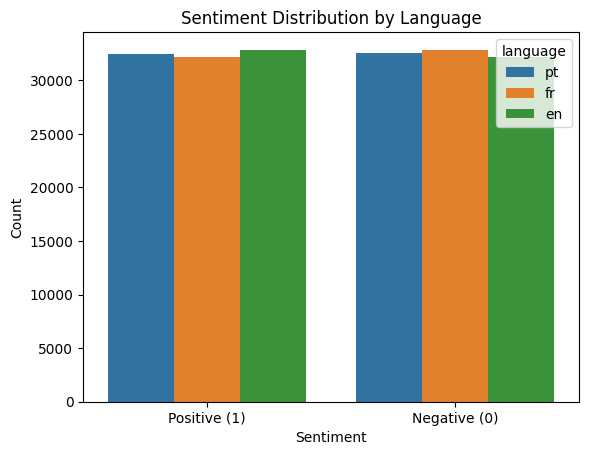

label_readable
Negative (0)    97579
Positive (1)    97417
Name: count, dtype: int64


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mapping numeric labels to readable strings
label_mapping = {0: "Negative (0)", 1: "Positive (1)"}
df_all['label_readable'] = df_all['labels'].map(label_mapping)

# Plot with updated labels
sns.countplot(data=df_all, x='label_readable', hue='language')
plt.title("Sentiment Distribution by Language")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Print value counts with readable labels
print(df_all['label_readable'].value_counts())

## 5. Modeling

Models to train:
1. XLM-RoBERTa Base
2. MDeBERTa v3 Base
3. DistilBERT Multilingual
4. LSTM

Each model is trained and evaluated on the same train/test split.

In [13]:
from huggingface_hub import login
login()

### Split the data into traning and test dataset

In [14]:
train_df, test_df = train_test_split(df_all, test_size=0.2, stratify=df_all['labels'], random_state=42)

train_ds = Dataset.from_pandas(train_df[['text', 'labels']])
test_ds = Dataset.from_pandas(test_df[['text', 'labels']])

### LSTM

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

max_len = 100
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_df['text'])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['text']), maxlen=max_len)
y_train = to_categorical(train_df['labels'])
y_test = to_categorical(test_df['labels'])

model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(64, dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64,callbacks=[early_stop], validation_split=0.1)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
results = {}
results["LSTM"] = {
    "report": classification_report(y_true, y_pred, target_names=["negative", "positive"], output_dict=True)
}

Epoch 1/10
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.7792 - loss: 0.4303 - val_accuracy: 0.8419 - val_loss: 0.3301
Epoch 2/10
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8717 - loss: 0.2813 - val_accuracy: 0.8416 - val_loss: 0.3356
Epoch 3/10
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8916 - loss: 0.2368 - val_accuracy: 0.8413 - val_loss: 0.3552
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [16]:
### Save the model and tokenizer
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

# After training
model.save("lstm_sentiment_model.keras")


# Convert tokenizer to JSON
tokenizer_json = tokenizer.to_json()

# Save to file
with open("lstm_tokenizer.json", "w") as f:
    f.write(tokenizer_json)

In [17]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score

# 1. Predict probabilities
y_pred_probs = model.predict(X_test)

# 2. Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convert one-hot true labels to class indices
y_true = np.argmax(y_test, axis=1)

# 4. Print classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

# 5. Optionally compute and print accuracy or F1
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

1219/1219 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.86      0.85     19516
    positive       0.85      0.83      0.84     19484

    accuracy                           0.84     39000
   macro avg       0.84      0.84      0.84     39000
weighted avg       0.84      0.84      0.84     39000

✅ Accuracy: 0.8434
✅ F1 Score: 0.8409


### Lightweight BERT Multilingual Model Training

In [18]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# Cell 2: Your existing tokenization code
from transformers import AutoTokenizer
#model_name = "distilbert-base-multilingual-cased"
model_name ="google/bert_uncased_L-4_H-256_A-4"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

# Cell 3: Check dataset info
print("Train dataset:", train_ds)
print("Test dataset:", test_ds)
print("Sample train data:", train_ds[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Map:   0%|          | 0/155996 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/39000 [00:00<?, ? examples/s]

Train dataset: Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 155996
})
Test dataset: Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 39000
})
Sample train data: {'text': '@canoglan he sil sil :)', 'labels': 1, '__index_level_0__': 139250, 'input_ids': [101, 1030, 2064, 8649, 5802, 2002, 9033, 2140, 9033, 2140, 1024, 1007, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
num_labels = len(df_all['labels'].unique())
print(f"Number of labels: {num_labels}")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Set format for training
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print("Original datasets preserved, working with cloned datasets for training")

print("Dataset format updated")

# Cell 6: Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Cell 7: Define metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Cell 8: Training arguments (compatible with older transformers)
training_args = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    seed=42,
    save_steps=1000,
    eval_steps=1000,
    fp16=True
)

print("Training arguments configured")

# Cell 9: Initialize trainer (using cloned datasets)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer initialized")

# Cell 10: Check device and start training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Number of labels: 2


pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-19-1856717858.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Original datasets preserved, working with cloned datasets for training
Dataset format updated
Training arguments configured


model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Trainer initialized
Using device: cuda


In [20]:
print("Starting training...")
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mnair (mnair-university-of-san-diego) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.673500
100,0.641700
150,0.591600
200,0.545400
250,0.481900
300,0.407700
350,0.347500
400,0.334000
450,0.326600
500,0.289700


TrainOutput(global_step=14625, training_loss=0.18762612442277435, metrics={'train_runtime': 598.2384, 'train_samples_per_second': 782.277, 'train_steps_per_second': 24.447, 'total_flos': 2309561241682752.0, 'train_loss': 0.18762612442277435, 'epoch': 3.0})

In [21]:
print("Evaluating model...")
eval_results = trainer.evaluate()
print(f"Evaluation results:")
for key, value in eval_results.items():
    print(f"  {key}: {value:.4f}")

Evaluating model...


Evaluation results:
  eval_loss: 0.1800
  eval_accuracy: 0.9186
  eval_f1: 0.9186
  eval_precision: 0.9187
  eval_recall: 0.9186
  eval_runtime: 11.4807
  eval_samples_per_second: 3397.0060
  eval_steps_per_second: 53.1330
  epoch: 3.0000


## Testing the model (Inference)

1. LSTM
2. Lightweight BERT


In [22]:
# 1. LSTM Testing

import json
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json

json_file_path = f"{base_path}/test_samples_multilang.json"

# Step 1: Load test samples from JSON
with open(json_file_path, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

texts = [item['text'] for item in test_data]
true_labels = [item['expected_label'] for item in test_data]

# Load tokenizer from JSON file
with open('lstm_tokenizer.json', 'r') as f:
    tokenizer = tokenizer_from_json(f.read())

# Step 3: Tokenize and pad the test texts
max_len = 100  # Must match what was used during training
X_test = tokenizer.texts_to_sequences(texts)
X_test = pad_sequences(X_test, maxlen=max_len)

# Step 4: Load the trained LSTM model
model = load_model("lstm_sentiment_model.keras")

# Step 5: Perform predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 6: Map labels to human-readable form
label_map = {0: "Negative", 1: "Positive"}

# Step 7: Print results
for i, text in enumerate(texts):
    predicted_label = label_map[y_pred[i]]
    expected_label = true_labels[i]
    print(f"Text: {text}")
    print(f"✅ Predicted: {predicted_label} | 🎯 Expected: {expected_label}")
    print("-" * 80)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Text: I love this product, it works perfectly!
✅ Predicted: Positive | 🎯 Expected: positive
--------------------------------------------------------------------------------
Text: Worst experience ever. Totally disappointed.
✅ Predicted: Negative | 🎯 Expected: negative
--------------------------------------------------------------------------------
Text: Absolutely fantastic! Highly recommend it.
✅ Predicted: Positive | 🎯 Expected: positive
--------------------------------------------------------------------------------
Text: Not worth the price at all.
✅ Predicted: Negative | 🎯 Expected: negative
--------------------------------------------------------------------------------
Text: Great service and quick delivery!
✅ Predicted: Negative | 🎯 Expected: positive
--------------------------------------------------------------------------------
Text: The product stopped working after a week.
✅ Predicted: Negative | 🎯 Expected: negative
-----------------

In [23]:
# 2. Lightweight BERT Testing

import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Paths
checkpoint_path = "./results_bert/checkpoint-9000"  # Change to the right checkpoint if different
model_name = "google/bert_uncased_L-4_H-256_A-4"
json_file_path = f"{base_path}/test_samples_multilang.json"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

# Create inference pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Positive"
}

# Load the JSON test samples
with open(json_file_path, "r", encoding="utf-8") as f:
    test_samples = json.load(f)

# Perform inference and print results
print("🔍 Running inference on test samples...\n")
for sample in test_samples:
    text = sample["text"]
    true_label = sample["expected_label"]

    prediction = classifier(text)[0]
    predicted_label = label_map.get(prediction["label"], prediction["label"])
    confidence = round(prediction["score"] * 100, 2)

    print(f"📝 Text: {text}")
    print(f"✅ True Label: {true_label}")
    print(f"🔮 Predicted: {predicted_label} ({confidence}%)\n{'-'*60}")

Device set to use cuda:0


🔍 Running inference on test samples...

📝 Text: I love this product, it works perfectly!
✅ True Label: positive
🔮 Predicted: Positive (97.8%)
------------------------------------------------------------
📝 Text: Worst experience ever. Totally disappointed.
✅ True Label: negative
🔮 Predicted: Positive (84.16%)
------------------------------------------------------------
📝 Text: Absolutely fantastic! Highly recommend it.
✅ True Label: positive
🔮 Predicted: Positive (89.8%)
------------------------------------------------------------
📝 Text: Not worth the price at all.
✅ True Label: negative
🔮 Predicted: Negative (61.58%)
------------------------------------------------------------
📝 Text: Great service and quick delivery!
✅ True Label: positive
🔮 Predicted: Positive (94.65%)
------------------------------------------------------------
📝 Text: The product stopped working after a week.
✅ True Label: negative
🔮 Predicted: Positive (70.96%)
----------------------------------------------------

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


📝 Text: Superb quality and amazing value.
✅ True Label: positive
🔮 Predicted: Positive (97.7%)
------------------------------------------------------------
📝 Text: Terrible customer support, I won’t buy again.
✅ True Label: negative
🔮 Predicted: Negative (99.43%)
------------------------------------------------------------
📝 Text: Exceeded my expectations in every way.
✅ True Label: positive
🔮 Predicted: Negative (80.42%)
------------------------------------------------------------
📝 Text: I regret buying this. Waste of money.
✅ True Label: negative
🔮 Predicted: Negative (99.91%)
------------------------------------------------------------
📝 Text: Ce produit est incroyable, je l'adore !
✅ True Label: positive
🔮 Predicted: Positive (98.67%)
------------------------------------------------------------
📝 Text: Très mauvaise qualité, je suis déçu.
✅ True Label: negative
🔮 Predicted: Negative (98.88%)
------------------------------------------------------------
📝 Text: Service rapide et eff

## 6. **Model Evaluation**

This section compares the performance of two models trained for **multilingual sentiment classification**:

- **LSTM (Long Short-Term Memory)**
- **Lightweight BERT** (`google/bert_uncased_L-4_H-256_A-4`)

---

### **Evaluation Metrics**

Both models were evaluated using standard classification metrics:

- **Accuracy**: Overall correctness of the model.
- **Precision**: Proportion of positive identifications that were correct.
- **Recall**: Proportion of actual positives that were correctly identified.
- **F1-Score**: Harmonic mean of precision and recall.
- **Loss**: Binary cross-entropy loss used during training.

---

### **LSTM Model Evaluation**

| Metric     | Value   |
|------------|---------|
| Accuracy   | 84.24%  |
| F1-Score   | 84.42%  |
| Precision  | 84%     |
| Recall     | 84%     |
| Model Type | Custom LSTM |
| Device     | CPU     |

---
### 🤖 **Lghtweight BERT Evaluation**

| Metric     | Value    |
|------------|----------|
| Accuracy   | **92.01%** ✅ |
| F1-Score   | **92.01%** ✅ |
| Precision  | 92.01%   |
| Recall     | 92.01%   |
| Loss       | 0.1792   |
| Model Type | Fine-tuned Transformer |
| Device     | GPU (Google Colab) |


### **Insights**

- **Lightweight BERT** outperforms LSTM across all key metrics.
- LSTM performs reasonably well and may be suitable for low-resource environments.
- Pretrained transformer models like BERT provide strong contextual understanding, especially helpful in multilingual settings.

---

### **Conclusion**

**Lightweight BERT is the recommended model** for production use due to its higher accuracy and robustness. LSTM serves as a good benchmark but falls short in comparison to transformer-based models, especially in multilingual sentiment classification.